In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import expon
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from datetime import datetime, timedelta
from dateutil.parser import parse
import math
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import os

import matplotlib.pyplot as plt

 
%matplotlib inline

Read csv and create figure size for notebook

In [3]:
plt.rcParams["figure.figsize"] = (20,10)
ufo = pd.read_csv('/Users/richardlafferty/Downloads/scrubbed.csv')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Rename columns for easier input

In [4]:
ufo.rename(columns = {'duration (seconds)':'duration_seconds',
                      'duration (hours/min)': 'duration_hrs_min',
                      'date posted': 'date_posted'}, inplace = True)

Replacing incompatible timestamps

In [5]:
ufo['datetime'] = ufo['datetime'].apply(lambda x: x + ':00')

In [6]:
ufo.datetime.replace('24:00:00', '00:00:00')


0        10/10/1949 20:30:00
1        10/10/1949 21:00:00
2        10/10/1955 17:00:00
3        10/10/1956 21:00:00
4        10/10/1960 20:00:00
5        10/10/1961 19:00:00
6        10/10/1965 21:00:00
7        10/10/1965 23:45:00
8        10/10/1966 20:00:00
9        10/10/1966 21:00:00
10       10/10/1968 13:00:00
11       10/10/1968 19:00:00
12       10/10/1970 16:00:00
13       10/10/1970 19:00:00
14       10/10/1971 21:00:00
15       10/10/1972 19:00:00
16       10/10/1972 22:30:00
17       10/10/1973 19:00:00
18       10/10/1973 23:00:00
19       10/10/1974 19:30:00
20       10/10/1974 21:30:00
21       10/10/1974 23:00:00
22       10/10/1975 17:00:00
23       10/10/1976 20:30:00
24       10/10/1976 22:00:00
25       10/10/1977 12:00:00
26       10/10/1977 22:00:00
27       10/10/1978 02:00:00
28       10/10/1979 00:00:00
29       10/10/1979 22:00:00
                ...         
80302      9/9/2012 20:00:00
80303      9/9/2012 20:10:00
80304      9/9/2012 20:30:00
80305      9/9

Seperating date from time

In [7]:
ufo['date'] = ufo['datetime'].map(lambda x: str(x)[:-8])
ufo['date'] = ufo['date'].str.strip()
ufo['year'] = ufo['date'].map(lambda x: str(x)[-4:])
ufo['year'] = ufo['year'].str.split('/')
ufo['time'] = ufo['datetime'].map(lambda x: str(x)[-8:])


Convert datetime by adding date and time seperately

In [8]:
ufo['datetime'] = pd.to_datetime(ufo.date) + pd.to_timedelta(ufo.time)

Change year column to be the year of datetime which is an integer

In [9]:
ufo['year'] = ufo['datetime'].dt.year

In [ ]:
ufo_total = ufo[(ufo['year'] >= 1949) & (ufo['year']) <= 2013]


In [10]:
print(ufo.datetime.dtypes)

datetime64[ns]


change latitude from an object to a float

In [11]:
ufo['latitude'] = pd.to_numeric(ufo['latitude'], errors = 'coerce')


Strip whitespace in longitude header

In [12]:
ufo.rename(columns = {'longitude ': 'longitude'}, inplace = True)

In [13]:
print(ufo['latitude'].mean())
print(ufo['longitude'].mean())
print(ufo['latitude'].median())
print(ufo['longitude'].median())


38.12447682461752
-86.77288454711757
39.41111110000001
-87.90361109999999


Changing the duration in seconds to a float

In [18]:
ufo['duration_seconds'] = pd.to_numeric(ufo.duration_seconds, errors = 'coerce')
print(ufo[duration_seconds].mean())

NameError: name 'duration_seconds' is not defined

In [15]:
for row_num, row in enumerate(ufo, start=1):
    try:
        pd.to_datetime(ufo.datetime, infer_datetime_format = True)
    except ValueError as err:
        print("Invalid data, row is skipped")
        print('Row: {}, Reason : {}'.format(row_num, err))
       
   

In [16]:
for row_num, row in enumerate(ufo, start=1):
    try:
        pd.to_numeric(ufo.duration_seconds)
    except ValueError as err:
        print("Invalid data, row is skipped")
        print('Row: {}, Reason : {}'.format(row_num, err))
    

In [17]:
print(ufo.dtypes)

datetime            datetime64[ns]
city                        object
state                       object
country                     object
shape                       object
duration_seconds           float64
duration_hrs_min            object
comments                    object
date_posted                 object
latitude                   float64
longitude                  float64
date                        object
year                         int64
time                        object
dtype: object


In [19]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world[world.name != 'Antarctica']

long_lat_points = [Point(xy) for xy in zip(ufo['longitude'], ufo['latitude'])]

crs = {"init": "epsg:4326"}


In [20]:
long_lat_points[:3]

States with most UFOs seen

In [21]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}
def full_statename(state, state_dict):
    states = []
    for i in state:
        for key, value in state_dict.items():
            if key == i:
                try:
                    states += value
                except ValueError:
                    pass
    return states
print(full_statename(ufo['state'], states))


[]


In [25]:
ufo['state'] = ufo.state.str.upper()
state_seen = ufo.groupby('state').state.agg(['count'])
#ufo['state_name'] = ufo['state'].apply(lambda x: states[x])
print(state_seen)


       count
state       
AB       333
AK       354
AL       691
AR       666
AZ      2689
BC       788
CA      9655
CO      1505
CT       968
DC        99
DE       183
FL      4200
GA      1347
HI       353
IA       707
ID       554
IL      2645
IN      1386
KS       653
KY       914
LA       598
MA      1358
MB       155
MD       911
ME       633
MI      2071
MN      1081
MO      1576
MS       415
MT       510
...      ...
NM       815
NS       143
NT        20
NV       905
NY      3219
OH      2425
OK       766
ON      1584
OR      1845
PA      2582
PE        17
PQ        90
PR        33
QC       178
RI       290
SA        30
SC      1076
SD       196
SK        98
TN      1193
TX      3677
UT       743
VA      1393
VT       307
WA      4268
WI      1333
WV       486
WY       205
YK         7
YT        13

[67 rows x 1 columns]


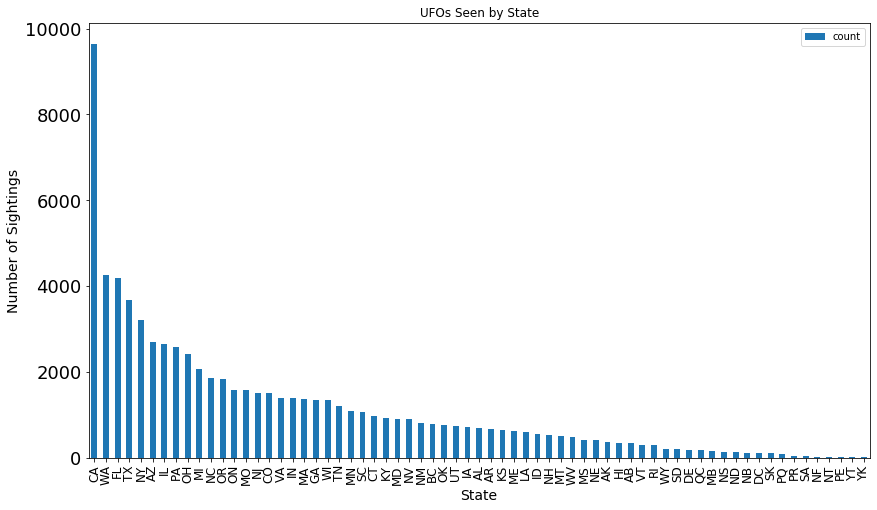

In [26]:
ax = state_seen.sort_values(by = 'count', ascending = False).plot(kind = 'bar',
                                                                  figsize = (14, 8),
                                                                  title = 'UFOs Seen by State', fontsize = 18)
ax.set_xlabel('State', fontsize = 14)
ax.set_ylabel('Number of Sightings', fontsize = 14)
ax.tick_params(axis = 'x', labelsize = 12)

CA    9655
WA    4268
FL    4200
TX    3677
NY    3219
Name: state, dtype: int64
CA    0.129536
WA    0.057262
FL    0.056349
TX    0.049333
NY    0.043188
Name: state, dtype: float64


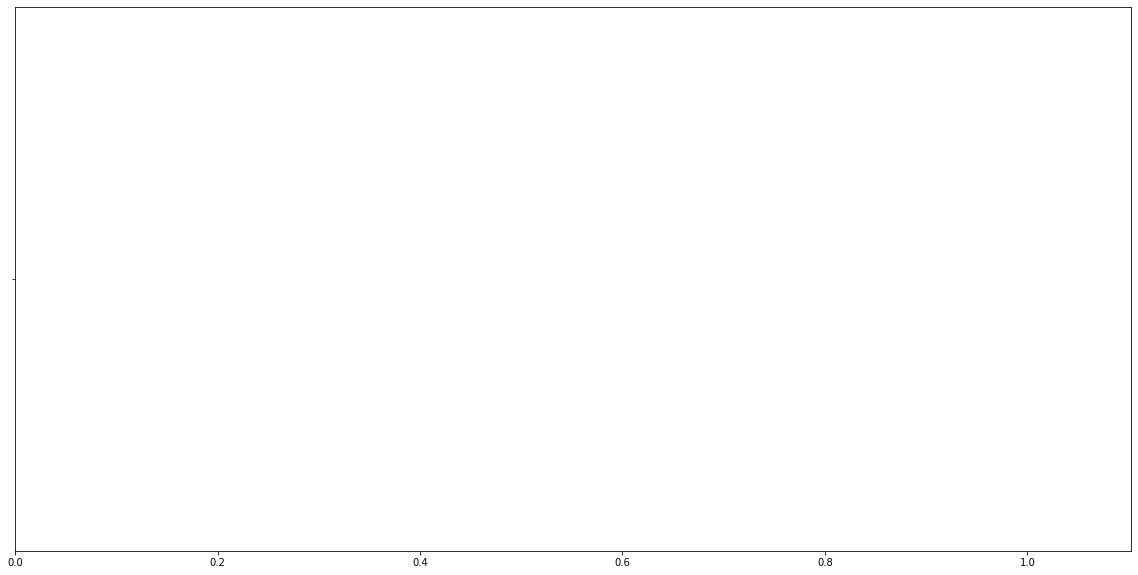

In [27]:
state_count = ufo.state.value_counts()
state_count_pct = ufo.state.value_counts(normalize = True)
print(state_count.head())
print(state_count_pct.head())
west_coast = ufo.loc[(ufo['state'] == 'CA') & (ufo['state'] == 'WA') & (ufo['state'] == 'OR')]
rest_country = ufo.loc[(ufo['state'] != 'NY') & (ufo['state'] != 'WA') & (ufo['state'] != 'OR')]

ax = sns.barplot(west_coast)

Plot a histogram of number of ufos seen by year

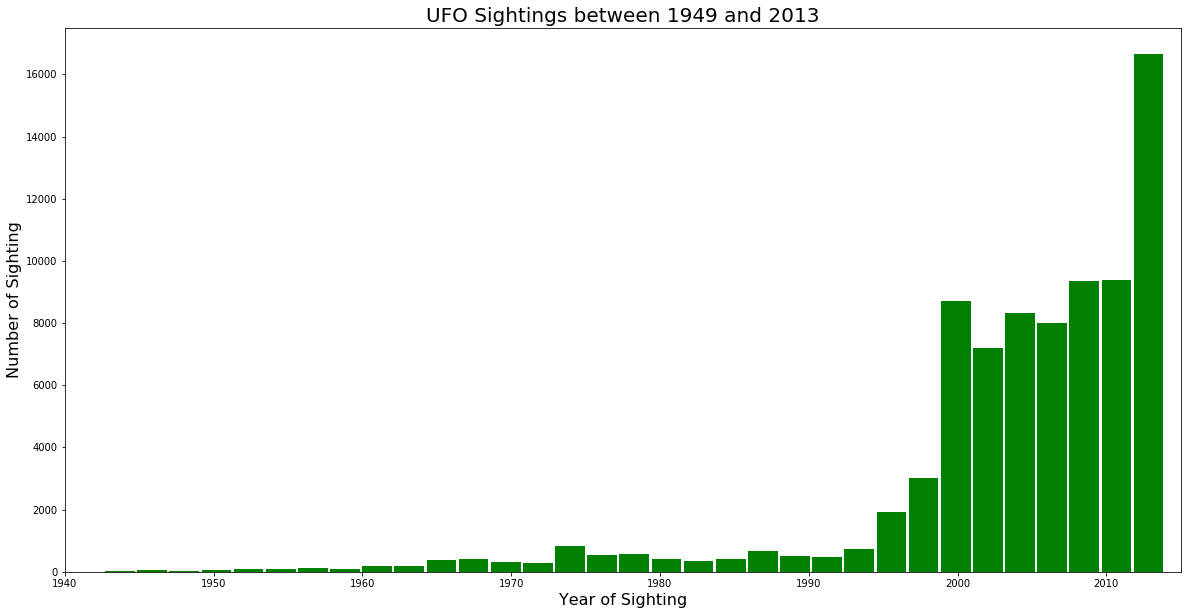

In [28]:
fig, ax = plt.subplots()
ax.hist(ufo['year'], bins = 50, color = 'green', width = 2)
ax.set_xlabel('Year of Sighting', fontsize = 16)
ax.set_ylabel('Number of Sighting', fontsize = 16)
ax.set_title('UFO Sightings between 1949 and 2013', fontsize = 20)
ax.set_xlim(1940, 2015)
data_expon = expon.rvs(scale=1,loc=0,size=1000)

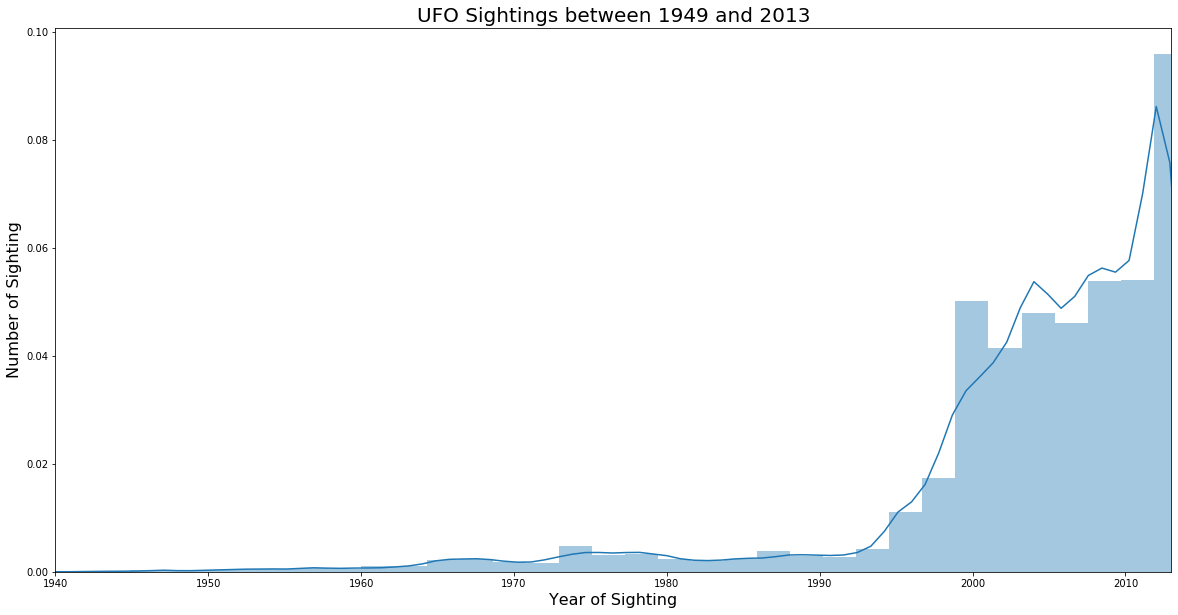

In [29]:
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.distplot(ufo['year'])
ax.set_xlabel('Year of Sighting', fontsize = 16)
ax.set_ylabel('Number of Sighting', fontsize = 16)
ax.set_title('UFO Sightings between 1949 and 2013', fontsize = 20)
ax.set_xlim(1940, 2013)

plt.show()

In [32]:
std_year = np.std(ufo['year'])
describe_year = ufo['year'].describe()
mean_year = np.mean(ufo['year'])
median_year = np.median(ufo['year'])
print(std_year)
print(mean_year)
print(median_year)
print(describe_year)

10.426782737269317
2003.8501095453867
2006.0
count    80332.000000
mean      2003.850110
std         10.426848
min       1906.000000
25%       2001.000000
50%       2006.000000
75%       2011.000000
max       2014.000000
Name: year, dtype: float64


New dataframe with only year, shape, and state seen

In [ ]:
ufo['before_2000'] = ufo.loc['year' < 2000]

In [ ]:
year_by_shape = ufo.groupby(['year', 'state', 'shape']).size().unstack().reset_index()

print(year_by_shape.head())

In [ ]:
ax = ufo.boxplot(column = ['year'], vert = False, showmeans = True)

print(ufo['year'].describe())


Finding different shapes seen and their counts

In [ ]:
shapes_seen = ufo.groupby('shape').shape.agg(['count'])

In [ ]:
print(shapes_seen)
print(shapes_seen.dtypes)


Barplot of shapes seen in descending order

In [ ]:
ax = shapes_seen.sort_values(by = 'count', ascending = False).plot(kind = 'bar',
                                                                  figsize = (14, 8),
                                                                  title = 'UFOs Seen by Shape', fontsize = 18)
ax.set_xlabel('Shape of UFO', fontsize = 14)
ax.set_ylabel('Number of Sightings', fontsize = 14)




Sighting duration in seconds

In [ ]:
#top ten shapes
light = ufo.loc[ufo['shape'] == 'light']
triangle = ufo.loc[ufo['shape'] == 'triangle']
circle = ufo.loc[ufo['shape'] == 'circle']
formation = ufo.loc[ufo['shape'] == 'formation']
oval = ufo.loc[ufo['shape'] == 'oval']
disk = ufo.loc[ufo['shape'] == 'disk']
sphere = ufo.loc[ufo['shape'] == 'sphere']
unknown = ufo.loc[ufo['shape'] == 'unknown']
other = ufo.loc[ufo['shape'] == 'other']
fireball = ufo.loc[ufo['shape'] == 'fireball']


In [ ]:
m = Basemap(projection = 'mill',
           llcrnrlat = 22,
           urcrnrlat = 55,
           llcrnrlon = -128,
           urcrnrlon = -60,
           resolution = 'c')
plt.title('UFO Sightings from 1949-2013', fontsize = 22)
m.drawcoastlines()
m.readshapefile('/Users/richardlafferty/Downloads/tl_2017_us_state/tl_2017_us_state', 'areas')
m.scatter(light.longitude.to_list(), light.latitude.to_list(), latlon = True, s = 10, c = 'magenta', alpha = .5)
m.scatter(triangle.longitude.to_list(), triangle.latitude.to_list(), latlon = True, s = 10, c = 'coral', marker = '^', alpha = .5)
m.scatter(circle.longitude.to_list(), circle.latitude.to_list(), latlon = True, s = 10, c = 'grey', marker = 'o', alpha = .5)
m.scatter(formation.longitude.to_list(), formation.latitude.to_list(), latlon = True, s = 10, c = 'pink', marker = 'D', alpha = .5)
m.scatter(oval.longitude.to_list(), oval.latitude.to_list(), latlon = True, s = 10, c = 'black', marker = 'd', alpha = .5)
m.scatter(disk.longitude.to_list(), disk.latitude.to_list(), latlon = True, s = 10, c = 'purple', marker = 'h', alpha = .5)
m.scatter(sphere.longitude.to_list(), sphere.latitude.to_list(), latlon = True, s = 10, c = 'yellow', marker = '8', alpha = .5)
m.scatter(unknown.longitude.to_list(), unknown.latitude.to_list(), latlon = True, s = 10, c = 'green', marker = '*', alpha = .5)
m.scatter(other.longitude.to_list(), other.latitude.to_list(), latlon = True, s = 10, c = 'blue', marker = 'X', alpha = .5)
m.scatter(fireball.longitude.to_list(), fireball.latitude.to_list(), latlon = True, s = 10, c = 'red', marker = 'p', alpha = .5)

In [ ]:
m = Basemap(projection = 'mill',
           llcrnrlat = 22,
           urcrnrlat = 55,
           llcrnrlon = -128,
           urcrnrlon = -60,
           resolution = 'c')
plt.title('UFO Sightings from 1949-2013', fontsize = 22)
m.drawparallels(np.arange(-90, 90, 10), labels = [True, False, False, False])
m.drawmeridians(np.arange(-180, 180, 30), labels = [0, 0, 0, 1])
m.drawcoastlines()
m.readshapefile('/Users/richardlafferty/Downloads/tl_2017_us_state/tl_2017_us_state', 'areas')
m.scatter(light.longitude.to_list(), light.latitude.to_list(), latlon = True, s = 10, c = 'magenta', alpha = .5)
m.scatter(triangle.longitude.to_list(), triangle.latitude.to_list(), latlon = True, s = 10, c = 'coral', marker = '^', alpha = .5)
m.scatter(circle.longitude.to_list(), circle.latitude.to_list(), latlon = True, s = 10, c = 'grey', marker = 'o', alpha = .5)
m.scatter(formation.longitude.to_list(), formation.latitude.to_list(), latlon = True, s = 10, c = 'pink', marker = 'D', alpha = .5)
m.scatter(oval.longitude.to_list(), oval.latitude.to_list(), latlon = True, s = 10, c = 'black', marker = 'd', alpha = .5)
m.scatter(disk.longitude.to_list(), disk.latitude.to_list(), latlon = True, s = 10, c = 'purple', marker = 'h', alpha = .5)
m.scatter(sphere.longitude.to_list(), sphere.latitude.to_list(), latlon = True, s = 10, c = 'yellow', marker = '8', alpha = .5)
m.scatter(unknown.longitude.to_list(), unknown.latitude.to_list(), latlon = True, s = 10, c = 'green', marker = '*', alpha = .5)
m.scatter(other.longitude.to_list(), other.latitude.to_list(), latlon = True, s = 10, c = 'blue', marker = 'X', alpha = .5)
m.scatter(fireball.longitude.to_list(), fireball.latitude.to_list(), latlon = True, s = 10, c = 'red', marker = 'p', alpha = .5)

In [ ]:
m = Basemap(projection = 'mill',
           llcrnrlat = 32,
           urcrnrlat = 43,
           llcrnrlon = -130,
           urcrnrlon = -114,
           resolution = 'c')
plt.title('UFO Sightings from 1949-2013', fontsize = 22)
m.drawcoastlines()
m.readshapefile('/Users/richardlafferty/Downloads/tl_2017_us_state/tl_2017_us_state', 'areas')
#m.scatter(light.longitude.to_list(), light.latitude.to_list(), latlon = True, s = 2, c = 'magenta', alpha = .5)
#m.scatter(triangle.longitude.to_list(), triangle.latitude.to_list(), latlon = True, s = 2, c = 'coral', marker = '^', alpha = .5)
#m.scatter(circle.longitude.to_list(), circle.latitude.to_list(), latlon = True, s = 2, c = 'grey', marker = 'o', alpha = .5)
#m.scatter(formation.longitude.to_list(), formation.latitude.to_list(), latlon = True, s = 2, c = 'pink', marker = 'D', alpha = .5)
#m.scatter(oval.longitude.to_list(), oval.latitude.to_list(), latlon = True, s = 2, c = 'black', marker = 'd', alpha = .5)
#m.scatter(disk.longitude.to_list(), disk.latitude.to_list(), latlon = True, s = 2, c = 'purple', marker = 'h', alpha = .5)
#m.scatter(sphere.longitude.to_list(), sphere.latitude.to_list(), latlon = True, s = 2, c = 'yellow', marker = '8', alpha = .5)
#m.scatter(unknown.longitude.to_list(), unknown.latitude.to_list(), latlon = True, s = 2, c = 'green', marker = '*', alpha = .5)
#m.scatter(other.longitude.to_list(), other.latitude.to_list(), latlon = True, s = 2, c = 'blue', marker = 'X', alpha = .5)
#m.scatter(fireball.longitude.to_list(), fireball.latitude.to_list(), latlon = True, s = 2, c = 'red', marker = 'p', alpha = .5)
m.scatter(ufo.longitude.to_list(), ufo.latitude.to_list(), latlon = True, s = 1, c = 'red')
m.scatter([-121.47, -122.45, -118.33, -117.15], [38.56, 37.75, 34.08, 32.81], latlon = True, s = 50, alpha = 1, label = 'San Francisco', c = 'black')

city_lons = [-121.47, -122.45, -118.33, -117.15]
city_lats = [38.56, 37.75, 34.08, 32.81]

In [ ]:
median_sighting = Point(38.1244768246185, -86.7728845471172)

In [ ]:
m = Basemap(projection='robin',lon_0=0,resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-90, 90, 10), labels = [True, False, False, False])
m.drawmeridians(np.arange(-180, 180, 30), labels = [0, 0, 0, 1])

m.scatter(ufo.longitude.to_list(), ufo.latitude.to_list(), latlon = True, s = 1, c = 'red')
plt.title('UFO Sightings Worldwide from 1949-2013', fontsize = 22, color = 'green')
plt.show()

In [ ]:
m = Basemap(projection = 'mill',
           llcrnrlat = 22,
           urcrnrlat = 55,
           llcrnrlon = -128,
           urcrnrlon = -60,
           resolution = 'c')
m.drawcoastlines()
m.readshapefile('/Users/richardlafferty/Downloads/tl_2017_us_state/tl_2017_us_state', 'areas')
m.scatter(ufo.longitude.to_list(), ufo.latitude.to_list(), latlon = True, s = 2, c = 'red')


In [ ]:
#Making two new data frames
ufo['year'] = ufo['year'].astype(int)
ufo_b4_1993 = ufo[ufo['year'] < 1993]
ufo_after_1993 = ufo[ufo['year'] >= 1993]

In [ ]:
ax = plt.subplot()
ax.hist(ufo_b4_1993['year'], bins = 50, color = 'green', width = 1.5)
ax.set_xlabel('Year of Sighting', fontsize = 16)
ax.set_ylabel('Number of Sighting', fontsize = 16)
ax.set_title('UFO sightings between 1949 and 2013', fontsize = 20)

ax.set_xlim(1940, 1996)


In [ ]:
ax = plt.subplot()
ax.hist(ufo_after_1993['year'], bins = 20, color = 'green', width = 1)
ax.set_xlabel('Year of Sighting', fontsize = 16)
ax.set_ylabel('Number of Sighting', fontsize = 16)
ax.set_title('UFO sightings between 1949 and 2013', fontsize = 20)

ax.set_xlim(1992, 2014)

In [ ]:
ttest_ind(ufo_b4_1993['year'], ufo_after_1993['year'], equal_var = False)